In [96]:
# Library imports
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
from qadence import *
from torch import (
    nn,
    optim,
    tensor,
    ones_like,
    rand,
    linspace,
    manual_seed,
    sin,
    exp,
)
from torch.autograd import grad

In [97]:
# Random seed
manual_seed(42)

# Helper function to calculate derivatives
def calc_derivative(outputs, inputs) -> tensor:
    """
    Returns the derivative of a function output
    with respect to its inputs.
    """
    if not inputs.requires_grad:
        inputs.requires_grad = True
    return grad(
        inputs=inputs,
        outputs=outputs,
        grad_outputs=ones_like(outputs),
        create_graph=True,
        retain_graph=True,
    )[0]

In [98]:
class Loss_func(nn.Module):
    """
    Collocation points sampling from domains using uniform random sampling.
    Problem-specific MSE loss function for solving the 2D Laplace equation.
    """

    def __init__(self, net: nn.Module | QNN, n_inputs: int = 2, n_colpoints: int = 100):
        super().__init__()
        self.net = net
        self.n_colpoints = n_colpoints
        self.n_inputs = n_inputs

    def left_boundary(self) -> tensor:  # u(0,y) = sin(pi*y)
        sample = rand(size=(self.n_colpoints, self.n_inputs))
        sample[:, 0] = 0.0
        return (self.net(sample)-sin(np.pi * sample[:, 1])).pow(2).mean()

    def right_boundary(self) -> tensor:  # u(1,y)
        sample = rand(size=(self.n_colpoints, self.n_inputs))
        sample[:, 0] = 1.0
        return (self.net(sample)-np.exp(-1 * np.pi)*sin(np.pi * sample[:,1])).pow(2).mean()

    def top_boundary(self) -> tensor:  # u(x,1) = 0
        sample = rand(size=(self.n_colpoints, self.n_inputs))
        sample[:, 1] = 1.0
        return (self.net(sample)).pow(2).mean()

    def bottom_boundary(self) -> tensor:  # u(x,0) = 0
        sample = rand(size=(self.n_colpoints, self.n_inputs))
        sample[:, 1] = 0.0
        return (self.net(sample)).pow(2).mean()

    def interior(self) -> tensor:  # uxx + uyy = 0
        sample = rand(size=(self.n_colpoints, self.n_inputs), requires_grad=True)
        first_both = calc_derivative(self.net(sample), sample)
        second_both = calc_derivative(first_both, sample)
        return (second_both[:, 0] + second_both[:, 1]).pow(2).mean()

In [99]:
# Hyperparameters
learning_rate = 0.01
n_qubits = 4
depth = 6
variable = ("x", "y")
n_points = 60
n_epochs = 1000

# Define a simple DQC model
ansatz = hea(n_qubits=n_qubits, depth=depth)

# Parallel Fourier feature map
split = n_qubits // len(variable)

# Construct the feature maps properly
feature_maps = [
    feature_map(n_qubits=split, support=support, param=param)
    for param, support in zip(variable,
        [
            list(range(n_qubits))[i : i + split]
            for i in range(0, n_qubits, split)
        ],
    )
]
fm = kron(*feature_maps)


# Choosing a cost function
obs = ising_hamiltonian(n_qubits=n_qubits)

# Building the circuit and the quantum model
circuit = QuantumCircuit(n_qubits, chain(fm, ansatz))
model = QNN(circuit=circuit, observable=obs, inputs=variable)

# Using Adam as an optimizer of choice
opt = optim.AdamW(model.parameters(), lr=learning_rate)


In [ ]:
# Get the collocation sampling for loss calculation
sol = Loss_func(net=model, n_inputs=2, n_colpoints=200)

# Training
for epoch in range(n_epochs + 1):
    opt.zero_grad()
    loss = (
        sol.left_boundary()
        + sol.right_boundary()
        + sol.top_boundary()
        + sol.bottom_boundary()
       + sol.interior()
    )
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Loss: {loss.item()}")

Epoch 0/1000, Loss: 116.8310229874097
Epoch 100/1000, Loss: 4.760875167661358
Epoch 200/1000, Loss: 4.860884242146576
Epoch 300/1000, Loss: 4.562449779941837
Epoch 400/1000, Loss: 4.593731494027999
Epoch 500/1000, Loss: 4.21084358218543
Epoch 600/1000, Loss: 4.3317354415207
Epoch 700/1000, Loss: 3.878302888319774
Epoch 800/1000, Loss: 4.32681676059211
Epoch 900/1000, Loss: 4.389921199658405
Epoch 1000/1000, Loss: 4.046026104002251


In [101]:
# Visualization and comparison of results
single_domain = linspace(0, 1, steps=n_points)
domain = tensor(list(product(single_domain, single_domain)))

# Analytical solution
analytic_sol = ((exp(-np.pi * domain[:, 0]) * sin(np.pi * domain[:, 1])).reshape(n_points, n_points))

# DQC solution
dqc_sol = model(domain).reshape(n_points, n_points).detach().numpy()

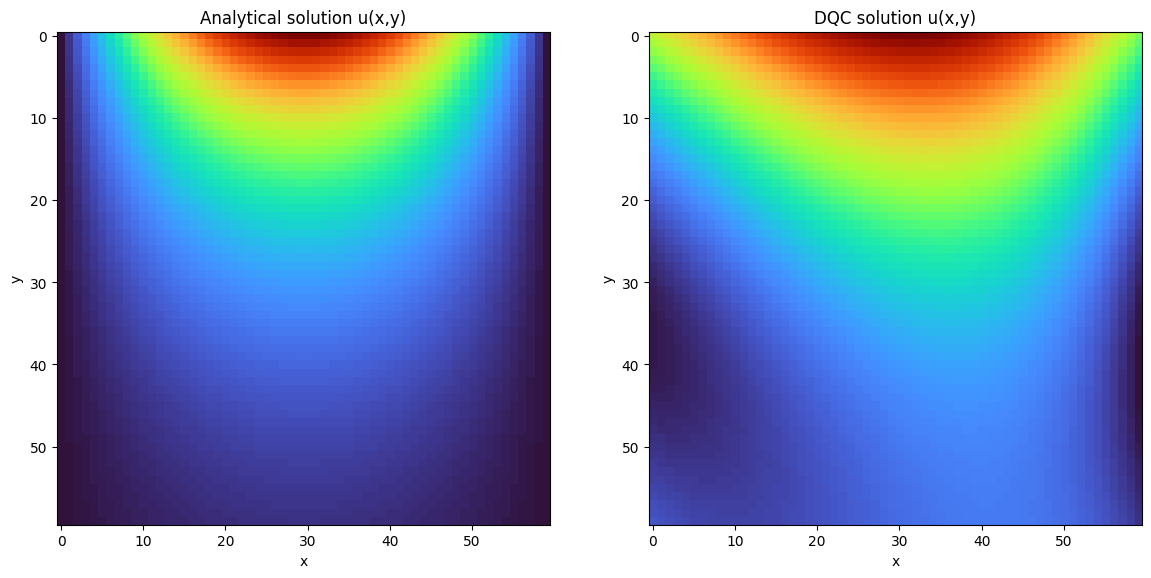

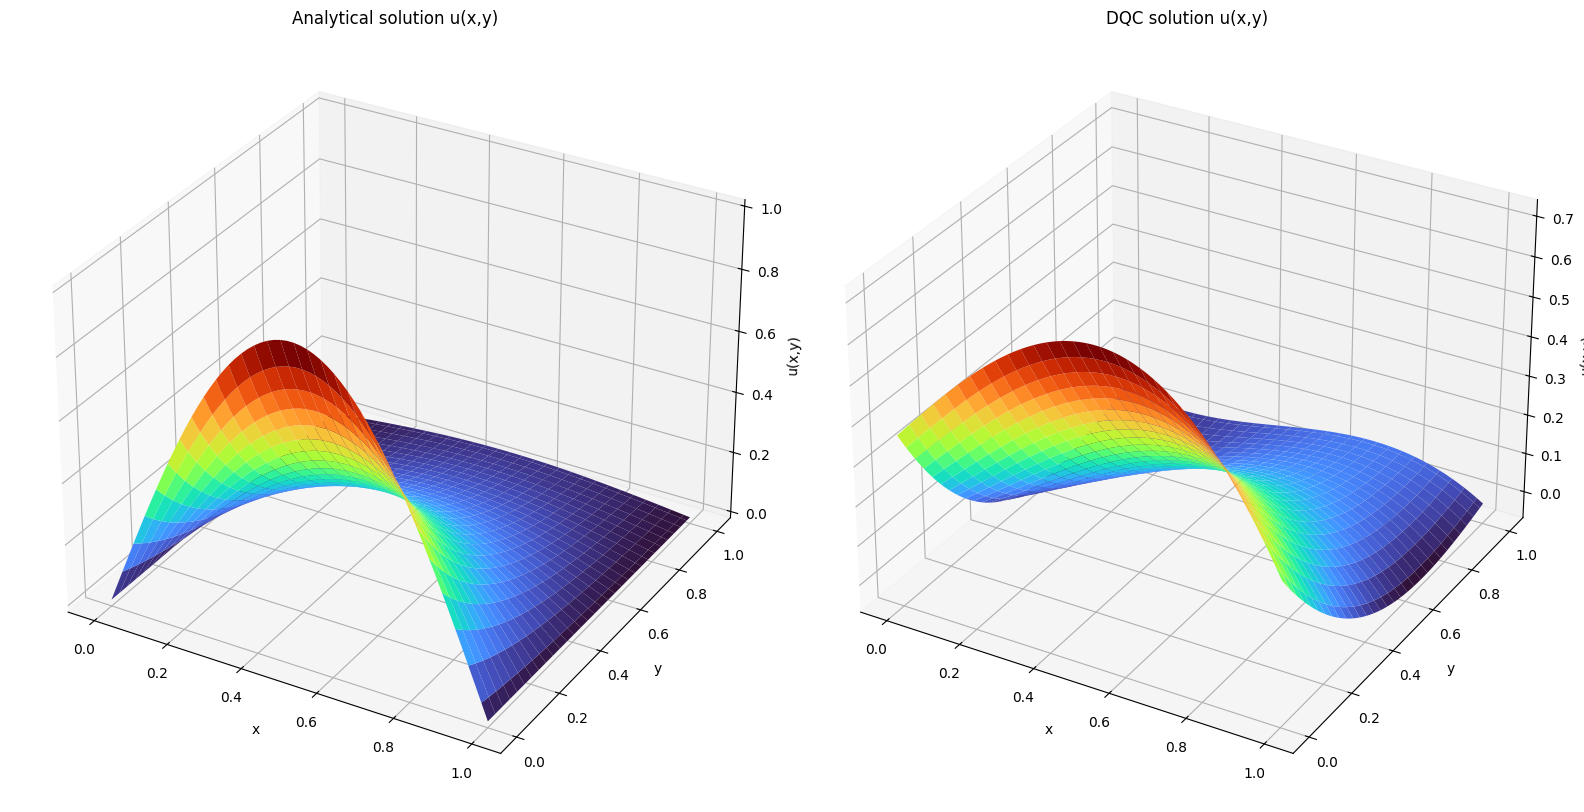

In [102]:
# Plot results (2D)
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].imshow(analytic_sol, cmap="turbo")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Analytical solution u(x,y)")
ax[1].imshow(dqc_sol, cmap="turbo")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("DQC solution u(x,y)")
plt.show()

# Plot results (3D)
X, Y = np.meshgrid(single_domain.numpy(), single_domain.numpy())
fig = plt.figure(figsize=(16, 8))

# 3D Analytical Solution
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, analytic_sol, cmap="turbo")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("u(x,y)")
ax1.set_title("Analytical solution u(x,y)")

# 3D DQC Solution
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, dqc_sol, cmap="turbo")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("u(x,y)")
ax2.set_title("DQC solution u(x,y)")

plt.tight_layout()
plt.show()
